In [9]:
import numpy as np
from numpy.random import seed, uniform, randint, random_sample, get_state, set_state
from zlib import adler32

class UHash(object):
    def __init__(self, useed):
        self.useed = useed
        self.sketch = 1.
        
    def do_hash(self, val):
        old_state = get_state()
        seed(adler32((str(self.useed) + str(val)).encode()))
        to_return = uniform()
        set_state(old_state)
        return to_return
    
    def do_update(self, val):
        y = self.do_hash(val)
        if self.sketch > y:
            self.sketch = y
            
    def get_sketch(self):
        return self.sketch


global_seeds = [randint(2000)+1 for _ in range(100)]

In [10]:
def make_stream(stream_len, num_distinct):
    """Sample values from a secret pool, with repititions."""
    secret_pool = list(range(num_distinct))
    for _ in range(stream_len):
        which = randint(low=0, high=len(secret_pool))
        yield 11+secret_pool[which]

In [11]:
from statistics import mean

golds, estimates = [], []

for num_distinct in (100, 150, 300, 450, 600, 750, 900, 1050, 1200):
    uhashes = [UHash(seed) for seed in global_seeds]
    uniques = set()
    stream = make_stream(2000, num_distinct)
    for x in stream:
        if x not in uniques:
            uniques.add(x)
        for uhash in uhashes:
            uhash.do_update(x)
    estimate = 1./mean([uh.get_sketch() for uh in uhashes]) - 1.
    golds.append(len(uniques))
    estimates.append(estimate)
    print(num_distinct, "actual", len(uniques), "estimate", estimate)

100 actual 100 estimate 133.6777582596872
150 actual 150 estimate 219.2942750997619
300 actual 300 estimate 309.60983286686434
450 actual 449 estimate 350.8792076482602
600 actual 575 estimate 391.4022882603934
750 actual 694 estimate 400.2440902046482
900 actual 816 estimate 462.90376229989533
1050 actual 894 estimate 521.528394343573
1200 actual 971 estimate 543.7888236239406


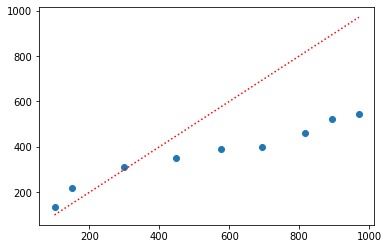

In [12]:
import matplotlib.pyplot as plt

plt.scatter(golds, estimates)
plt.plot(golds, golds, "r:")
plt.show()